# Builtraing a layered API with Fashion MNIST

Tags: python, data, fastai

date: 2022-05-23T19:05:13+10:00

feature_image: /images/fashion_mnist_training_loop.jpg
  
<!--eofm-->

We're going to build up a simple Deep Learning API inspired by [fastai](https://docs.fast.ai/) on Fashion MNIST from scratch.
Humans can only fit so many things in their head at once (somewhere between 3 and 7); trying to grasp all the details of the training loop at once is difficult, especially as we add more features to it.
The right abstractions can make this much easier by only having to think about what we're changing in the interface.
Coming up with a good abstraction that generalises across many usecases is hard, so we're going to use the fast.ai interface.

Then to show how it's useful once we have our training loop we'll see how we can change the model and retrain.

This post was generated with a Jupyter notebook. You can also [view this notebook on Kaggle](https://www.kaggle.com/code/edwardjross/building-layered-api-with-fashion-mnist/notebook) or [download the Jupyter notebook](/notebooks/building-layered-api-with-fashion-mnist.ipynb).

# Basic Training Loop

We're going to start where we finished with [Peeling fastai's layered API with Fashion MNIST](https://www.kaggle.com/code/edwardjross/peeling-fastai-layered-api-with-fashion-mnist) with a very low level training loop.

We'll use only a few imports.

In [1]:
import numpy as np
from torch import tensor, empty, stack, arange, randn, randperm, no_grad
from torch.nn.functional import cross_entropy

We have a two layer neural net with random parameters

In [2]:
def init_params(size, std=1.0): return (randn(size)*std).requires_grad_()    

w1, b1 = init_params((784, 100)), init_params((100,))
w2, b2 = init_params((100, 10)), init_params((10,))
params = [w1, w2, b1, b2]

def model(x):
    act1 = x@w1 + b1
    act2 = act1 * (act1 > 0)
    act3 = act2@w2 + b2
    return act3

Load in the training data and create a validation split

In [3]:
data = np.loadtxt('../input/fashionmnist/fashion-mnist_train.csv', skiprows=1, delimiter=',')

valid_mask = np.random.choice([True, False], len(data), p=(0.2, 0.8))
X_train, y_train = tensor(data[~valid_mask, 1:].astype(np.float32) / 255.), tensor(data[~valid_mask,0].astype(np.int64))
X_valid, y_valid = tensor(data[ valid_mask, 1:].astype(np.float32) / 255.), tensor(data[ valid_mask,0].astype(np.int64))

Define accuracy; how often the most probable class is the correct class

In [4]:
def accuracy(pred, y): return sum(y.flatten() == pred.argmax(axis=1)) / len(y)

It should start off around 10%, since there are 10 classes with equal data.

In [5]:
accuracy(model(X_valid), y_valid)

tensor(0.1191)

And run our training loop

In [6]:
batch_size = 2048
lr = 0.2

for epoch in range(5):
    for _batch in range(len(X_train) // batch_size):
        # Data loader
        idx = np.random.choice(len(X_train), batch_size, replace=False)
        X, y = X_train[idx], y_train[idx]
        
        pred = model(X)
        loss = cross_entropy(pred, y)
        loss.backward()
        with no_grad():
            for p in params:
                p -= lr * p.grad
                p.grad.zero_()
                
            
    print(epoch, accuracy(model(X_valid), y_valid))

0 tensor(0.5306)
1 tensor(0.5884)
2 tensor(0.6121)
3 tensor(0.6290)
4 tensor(0.6440)


# Abstracting the Optimiser

In PyTorch terms the [Optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.Optimizer) is the thing that stores the parameters, updates them by their parameters and can zero their gradients.
It's what we use in the `torch.no_grad`.

From a mathematical perspective I'd call the whole training loop the optimizer; it's finding the parameters that minimize the loss.
But the optimizer is a convenient abstraction because there are many other gradient based alternatives to Stochastic Gradient Descent.

We'll create a simplified version of the PyTorch optimizer for Stochastic Gradient Descent (a fastai Optimizer is a little different but they provide [OptimWrapper](https://docs.fast.ai/optimizer#OptimWrapper) for compatibility).

In [7]:
class SGD():
    def __init__(self, params, lr):
        self.params = list(params)
        self.lr = lr
        
    def step(self):
        for p in self.params:
            p -= lr * p.grad
            
    def zero_grad(self):
        for p in self.params:
            p.grad.zero_()

Reset the parameters

In [8]:
w1, b1 = init_params((784, 100)), init_params((100,))
w2, b2 = init_params((100, 10)), init_params((10,))
params = [w1, w2, b1, b2]

And training gives about the same accuracy as before.
The benefit here is we can now drop in a different optimizer.

In [9]:
batch_size = 2048

optim = SGD(params, lr=0.2)

for epoch in range(5):
    for _batch in range(len(X_train) // batch_size):
        idx = np.random.choice(len(X_train), batch_size, replace=False)
        X, y = X_train[idx], y_train[idx]
        
        pred = model(X)
        loss = cross_entropy(pred, y)
        loss.backward()
        with no_grad():
            optim.step()
            optim.zero_grad()
            
    print(epoch, accuracy(model(X_valid), y_valid))

0 tensor(0.6504)
1 tensor(0.6775)
2 tensor(0.6870)
3 tensor(0.6964)
4 tensor(0.7051)


# 2. Abstracting the model

We've been manually tracking our parameters for the Optimizer, but it would be nice just to get it out of the module.
PyTorch's [nn.module](https://pytorch.org/docs/stable/_modules/torch/nn/modules/module.html#Module) does this by tracking all [`Parameter`s](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html#torch.nn.parameter.Parameter) in the class and recursively any submodules.

The `Parameter` idea is important because we don't want to differentiate *every* method.
Parameter itself seems to have [deep magic in it's source](https://pytorch.org/docs/stable/_modules/torch/nn/parameter.html#Parameter); in particular it calls `Tensor._make_subclass`. We'll just manually track the parameters for now.

In [10]:
def init_params(size, std=1.0): return (randn(size)*std).requires_grad_()    

A Linear layer has the weight and the bias, and does a matrix multiplication.

We'll provide a way to reset the parameters (to restart model training), and to get the parameters for the optimizer.

In [11]:
class Linear:
    def __init__(self, in_features, out_features):
        self.in_features = in_features
        self.out_features = out_features
        self.weight = empty((self.in_features, self.out_features), requires_grad=True)
        self.bias = empty(self.out_features, requires_grad=True)
        self.reset_parameters()
        
    def __call__(self, x):
        return x @ self.weight + self.bias
    
    def reset_parameters(self):
        with no_grad():
            # Update the weights in place, otherwise the optimizer will point to the old weights
            self.weight[:] = init_params((self.in_features, self.out_features))
            self.bias[:] = init_params(self.out_features)
    
    def parameters(self):
        return [self.weight, self.bias]

The ReLU is a simple function with no parameters

In [12]:
class ReLU():
    def __call__(self, x):
         return x * (x > 0)
        
    def reset_parameters(self):
        pass
        
    def parameters(self):
        return []

To combine them we use a Sequential wrapper which just holds the other models.

In [13]:
class Sequential():
    def __init__(self, *modules):
        self.modules = modules
        
    def __call__(self, x):
        for module in self.modules:
            x = module(x)
        return x
    
    def reset_parameters(self):
        for module in self.modules:
            module.reset_parameters()
    
    def parameters(self):
        return (parameter for module in self.modules for parameter in module.parameters())

We can now rewrite our model in a much simpler way.
It's easier to see here how to add or remove layers.

In [14]:
model = Sequential(
    Linear(784, 100),
    ReLU(),
    Linear(100, 10),
)

In [15]:
accuracy(model(X_valid), y_valid)

tensor(0.0996)

Our training is the same as before, but we can now just pass the model parameters onto the optimizer rather than tracking them manually.

In [16]:
batch_size = 2048

optim = SGD(model.parameters(), lr=0.2)

for epoch in range(5):
    for _batch in range(len(X_train) // batch_size):
        idx = np.random.choice(len(X_train), batch_size, replace=False)
        X, y = X_train[idx], y_train[idx]
        
        pred = model(X)
        loss = cross_entropy(pred, y)
        loss.backward()
        with no_grad():
            optim.step()
            optim.zero_grad()
            
    print(epoch, accuracy(model(X_valid), y_valid))

0 tensor(0.5299)
1 tensor(0.5669)
2 tensor(0.6272)
3 tensor(0.6368)
4 tensor(0.6443)


Let's check resetting the parameters puts the accuracy back down to ~10%

In [17]:
accuracy(model(X_valid), y_valid)

tensor(0.6443)

In [18]:
model.reset_parameters()

In [19]:
accuracy(model(X_valid), y_valid)

tensor(0.1337)

# Dataloader

The logic to iterate through the data is pretty cumbersome, PyTorch provides a [DataLoader](https://pytorch.org/docs/stable/_modules/torch/utils/data/dataloader.html#DataLoader) abstraction that can wrap a Dataset, iterate through the indices, and output batches of tensors in an efficient way.


Let's start with a 

In [20]:
dataset = list(zip(X_train, y_train))

seq = randperm(len(dataset))
seq

tensor([38425,  7127, 40663,  ..., 40637, 15060, 16765])

Get a batch, here of size 4

In [21]:
batch_idxs = seq[:4]
batch_idxs

tensor([38425,  7127, 40663, 38173])

When we get the elements it has both the Xs and the ys together

In [22]:
batch = [dataset[idx] for idx in batch_idxs]

We can unpack them to get tuples of tensors

In [23]:
Xs, ys = zip(*batch)
type(Xs), len(Xs), type(ys), len(ys)

(tuple, 4, tuple, 4)

Then we can collate them into a batch by stacking them

In [24]:
X = stack(Xs)
y = stack(ys)
X.shape, y.shape

(torch.Size([4, 784]), torch.Size([4]))

We can iterate over minibatches with this little generator pattern

In [25]:
seq = arange(22)
[seq[i:i+5] for i in range(0, len(seq), 5)]

[tensor([0, 1, 2, 3, 4]),
 tensor([5, 6, 7, 8, 9]),
 tensor([10, 11, 12, 13, 14]),
 tensor([15, 16, 17, 18, 19]),
 tensor([20, 21])]

Let's put all this into a class

In [26]:
class DataLoader:
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.batch_size = batch_size
        self.dataset = dataset
        self.shuffle = shuffle
        
    def __iter__(self):
        seq = randperm(len(self)) if self.shuffle else arange(len(self))
        for batch_idxs in [seq[i:i+self.batch_size] for i in range(0, len(seq), self.batch_size)]:
            batch = [self.dataset[idx] for idx in batch_idxs]
            Xs, ys = zip(*batch)
            X, y = stack(Xs), stack(ys)
            yield X, y
            
    def __len__(self):
        return len(self.dataset)

And we get a similar performance to before

In [27]:
model.reset_parameters()

ds_train = list(zip(X_train, y_train))
dl_train = DataLoader(ds_train, batch_size=2048, shuffle=True)

for epoch in range(5):
    for X, y in dl_train:
        pred = model(X)
        loss = cross_entropy(pred, y)
        loss.backward()
        with no_grad():
            optim.step()
            optim.zero_grad()
            
    print(epoch, accuracy(model(X_valid), y_valid))

0 tensor(0.5396)
1 tensor(0.5852)
2 tensor(0.6102)
3 tensor(0.6212)
4 tensor(0.6303)


## Running metrics

If we want to evaluate on large datasets we need a way to accumulate the metric over minibatches.

How this is framed is surprisingly non-standard; we'll keep to the spirit of fastai (but not the implementation which uses callbacks), but there's also an external library [torchmetrics](https://torchmetrics.readthedocs.io/en/stable/), and huggingface have a different concept of [Metric](https://huggingface.co/docs/datasets/v2.2.1/en/package_reference/main_classes#datasets.Metric).

In [28]:
ds_valid = list(zip(X_valid, y_valid))
dl_valid = DataLoader(ds_valid, batch_size=2048, shuffle=False)

In [29]:
accuracy(model(X_valid), y_valid)

tensor(0.6303)

To calculate a running metric we'll just add the accuracy, weighted by the size of the sample, divided by the length of the dataset.

In [30]:
def running(metrics, dl, model):
    values = [0.] * len(metrics)
    N = len(dl)
    
    for X, y in dl:
        pred = model(X)
        for idx, metric in enumerate(metrics):
            values[idx] += metric(pred, y) * len(X) / N
    return [v.item() if hasattr(v, 'item') else v for v in values]

This gives a similar result to before.


Here we track:

* loss on the training set
* loss on validation set
* accuracy

Ideally we'd calculate a running total of loss on the training set, but this is good enough for now.

In [31]:
model.reset_parameters()

# Note: reset creates new parameters. Could we update them instead?
optim = SGD(model.parameters(), lr=0.2)

ds_train = list(zip(X_train, y_train))
dl_train = DataLoader(ds_train, batch_size=2048, shuffle=True)

metrics = [cross_entropy, accuracy]

for epoch in range(5):
    for X, y in dl_train:
        pred = model(X)
        loss = cross_entropy(pred, y)
        loss.backward()
        with no_grad():
            optim.step()
            optim.zero_grad()
    
    print(epoch, *running([cross_entropy], dl_train, model), *running(metrics, dl_valid, model))

0 2.9654173851013184 2.9218735694885254 0.5206032991409302
1 2.110874652862549 2.095884323120117 0.5787869095802307
2 1.7752487659454346 1.7723487615585327 0.6119169592857361
3 1.5830714702606201 1.5869991779327393 0.6269984841346741
4 1.4491684436798096 1.4574403762817383 0.6405142545700073


## Learner

We can now package up all our objects into a single class, our Learner.

In [32]:
from dataclasses import dataclass
from typing import Callable, List

class Learner:
    def __init__(self,
                 dl_train: DataLoader,
                 dl_valid: DataLoader,
                 loss_func: Callable,
                 model: Callable,
                 lr: float,
                 opt_func: Callable = SGD,
                 metrics: List[Callable] = None):
        self.dl_train = dl_train
        self.dl_valid = dl_valid
        self.loss_func = loss_func
        self.model = model
        self.lr = lr
        self.optim = opt_func(model.parameters(), lr)
        self.metrics = metrics if metrics is not None else [loss_func]
        
    def reset(self):
        self.model.reset_parameters()
    
    
    def fit(self, n_epoch):
        for epoch in range(n_epoch):
            for X, y in self.dl_train:
                pred = self.model(X)
                loss = self.loss_func(pred, y)
                loss.backward()
                with no_grad():
                    self.optim.step()
                    self.optim.zero_grad()
                    
            print(epoch, *running([self.loss_func], self.dl_train, self.model), *running(self.metrics, self.dl_valid, self.model))

In [33]:
metrics = [cross_entropy, accuracy]

learn = Learner(dl_train, dl_valid, cross_entropy, model, 0.2, SGD, metrics)

We can now train this for a bunch of epochs, getting around 74% accuracy.

In [34]:
model.reset_parameters()

learn.fit(40)

0 3.2126216888427734 3.283143997192383 0.5618098378181458
1 2.278181314468384 2.346566915512085 0.5942805409431458
2 1.8557775020599365 1.910788655281067 0.6112576127052307
3 1.6559522151947021 1.710391640663147 0.6208175420761108
4 1.5421751737594604 1.5935988426208496 0.634827733039856
5 1.3805128335952759 1.4289369583129883 0.6319432854652405
6 1.3306803703308105 1.3788357973098755 0.6361463665962219
7 1.2377548217773438 1.2862215042114258 0.6534531116485596
8 1.2100512981414795 1.2579960823059082 0.6574913263320923
9 1.152338981628418 1.19868803024292 0.6574089527130127
10 1.1125177145004272 1.159442663192749 0.6635899543762207
11 1.083337426185608 1.1281803846359253 0.6678754091262817
12 1.0920311212539673 1.137237787246704 0.6494148373603821
13 1.0610631704330444 1.1104097366333008 0.6719960570335388
14 1.0184332132339478 1.0690116882324219 0.6782594323158264
15 1.0005489587783813 1.0493626594543457 0.668452262878418
16 1.0299843549728394 1.076596736907959 0.6588099598884583
17 0

# The benefits of abstraction

Now that we everything in our learner it's much easier to focus on small changes to the components.

### Changing the model: Init well

Let's put a torch linear layer in our model

In [35]:
import torch.nn

In [36]:
torch_model = Sequential(
    torch.nn.Linear(784, 100),
    ReLU(),
    torch.nn.Linear(100, 10),
)

In just a few epochs it outperforms our previous model.
What does it do differently?

In [37]:
torch_learn = Learner(dl_train, dl_valid, cross_entropy, torch_model, lr=2, metrics=metrics)
torch_learn.fit(10)

0 1.0736732482910156 1.068850040435791 0.6171913743019104
1 0.8725801706314087 0.8647670149803162 0.7031481862068176
2 0.7314574718475342 0.7330614328384399 0.7289434671401978
3 0.6415749788284302 0.6435913443565369 0.7758365273475647
4 0.6304138898849487 0.6356835961341858 0.776248574256897
5 0.6219738721847534 0.6234530210494995 0.7640514373779297
6 0.6262473464012146 0.6312569975852966 0.7718806862831116
7 0.5853808522224426 0.5870252251625061 0.7842426896095276
8 0.5925256013870239 0.591513991355896 0.7968518137931824
9 0.5194151401519775 0.523120641708374 0.8157244324684143


Looking at [the source](https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear) we see this:

```
    def reset_parameters(self) -> None:
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(in_features), 1/sqrt(in_features)). For details, see
        # https://github.com/pytorch/pytorch/issues/57109
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)
```

Looking up Kaiming Initialisation brings us to [this paper](https://arxiv.org/abs/1502.01852) which says:

> This leads to a zero-mean Gaussian distribution whose standard eviation (std) is $\sqrt{2/n_l}$. This is our way of initialization. We also initialize b=0.

Let's try this

In [38]:
class LinearKaiming(Linear):
    def reset_parameters(self):
        with no_grad():
            self.weight[:] = init_params((self.in_features, self.out_features), np.sqrt(2/self.in_features))
            self.bias[:] = torch.zeros_like(self.bias)

We get similar performance to the torch model.
Initialisation is very important in deep networks, but even in this small model it makes a difference.

In [39]:
model_kaiming=Sequential(
    LinearKaiming(784, 100),
    ReLU(),
    LinearKaiming(100, 10),
)

learn = Learner(dl_train, dl_valid, cross_entropy, 
                model_kaiming, 0.2, SGD, metrics)
learn.fit(25)

0 0.9928680658340454 0.9959338307380676 0.6848524212837219
1 0.7061344981193542 0.7092622518539429 0.7604252099990845
2 0.6784164309501648 0.6813119649887085 0.7513598203659058
3 0.6543854475021362 0.6544392108917236 0.7633921504020691
4 0.5760871767997742 0.5763159990310669 0.796934187412262
5 0.557142436504364 0.56104975938797 0.8028680086135864
6 0.54227215051651 0.5469540953636169 0.8106972575187683
7 0.5124587416648865 0.5161428451538086 0.8195978403091431
8 0.5065622925758362 0.5089733600616455 0.8235536217689514
9 0.505312979221344 0.512185275554657 0.8147355318069458
10 0.467585027217865 0.47441017627716064 0.8371517658233643
11 0.4726341962814331 0.48188284039497375 0.8276743292808533
12 0.5650492906570435 0.577560305595398 0.7956980466842651
13 0.48750507831573486 0.4999195337295532 0.8224822878837585
14 0.46887752413749695 0.47312453389167786 0.8339377045631409
15 0.49850377440452576 0.5068738460540771 0.8112741708755493
16 0.5208178758621216 0.524056077003479 0.804763436317

# Changing the optimizer

We could just drop in another optimizer; in this case using momentum with SGD may improve the result a little (or may not change it much).

In [40]:
from torch.optim import SGD as SGDTorch

In [41]:
model_kaiming.reset_parameters()

optim = lambda params, lr: SGDTorch(params, lr, momentum=0.5)

learn = Learner(dl_train, dl_valid, cross_entropy, 
                model_kaiming, 0.2, optim, metrics)
learn.fit(25)

0 0.7095286846160889 0.7120507955551147 0.7463326454162598
1 0.6111636161804199 0.614683985710144 0.7810285091400146
2 0.5852203965187073 0.5961494445800781 0.7928135991096497
3 0.538330078125 0.5422188639640808 0.8088841438293457
4 0.4959908723831177 0.5010000467300415 0.8273446559906006
5 0.46879303455352783 0.47862324118614197 0.8326190710067749
6 0.46012142300605774 0.4713790714740753 0.8298170566558838
7 0.49200674891471863 0.5036535263061523 0.8119333982467651
8 0.44662147760391235 0.4583902060985565 0.8379758596420288
9 0.4196605086326599 0.431936651468277 0.849843442440033
10 0.4195310175418854 0.43150192499160767 0.8476182818412781
11 0.42625564336776733 0.4413745701313019 0.8369045853614807
12 0.4185228943824768 0.4318638741970062 0.8504202961921692
13 0.43430835008621216 0.44915223121643066 0.8333607912063599
14 0.3900304138660431 0.4056735634803772 0.8563540577888489
15 0.4116860628128052 0.42807069420814514 0.8497610092163086
16 0.39633578062057495 0.41715002059936523 0.85

# Changing the data preparation

Let's try some data augmentation by moving the image around a few pixels

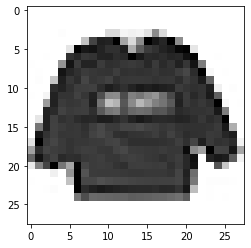

In [42]:
x = X_train[0,:]
img = x.reshape(28,28)


import matplotlib.pyplot as plt

plt.imshow(img, cmap='Greys')

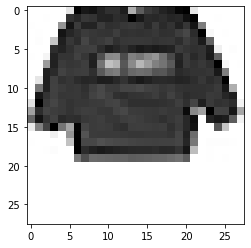

In [43]:
def shift_down(img, px):
    return torch.cat([img[px:,:], torch.zeros((px, 28))], axis=0)

plt.imshow(shift_down(img, 5), cmap='Greys')

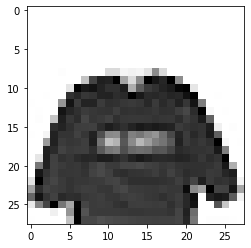

In [44]:
def shift_up(img, px):
    return torch.cat([torch.zeros((px, 28)), img[:-px,:]], axis=0)

plt.imshow(shift_up(img, 5), cmap='Greys')

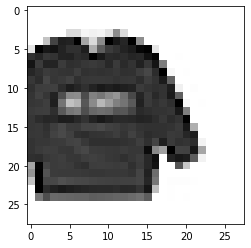

In [45]:
def shift_left(img, px):
    return torch.cat([img[:,px:], torch.zeros((28, px))], axis=1)

plt.imshow(shift_left(img, 5), cmap='Greys')

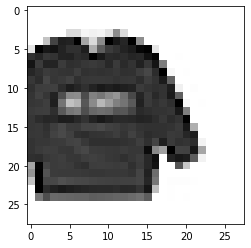

In [46]:
def shift_right(img, px):
    return torch.cat([torch.zeros((28, px)), img[:,:-px]], axis=1)

plt.imshow(shift_left(img, 5), cmap='Greys')

In [47]:
max_px = 4

def augment(x):
    img = x.reshape(28, 28)
    px = np.random.choice(max_px)
    direction = np.random.choice([shift_left, shift_right, shift_up, shift_down])
    
    if px > 0:
        img_aug = direction(img, px)
    else:
        img_aug = img
    return img_aug.reshape(784)

In [48]:
class AugmentedDataset:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __getitem__(self, idx):
        x, y = self.X[idx], self.y[idx]
        return (augment(x), y)
    
    def __len__(self):
        return len(self.X)

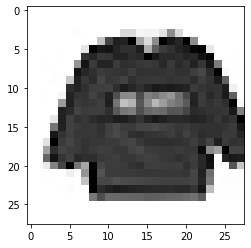

In [49]:
ds_train_aug = AugmentedDataset(X_train, y_train)

x, y = ds_train_aug[0]
plt.imshow(x.reshape(28,28), cmap='Greys')

In [50]:
dl_train_aug = DataLoader(ds_train_aug, batch_size=2048, shuffle=True)

In this case it runs much slower and doesn't seem to help accuracy.
Part of the reason is the images are already centre cropped, and partly because the model isn't overfitting

In [51]:
model_kaiming.reset_parameters()

learn = Learner(dl_train_aug, dl_valid, cross_entropy, 
                model_kaiming, 0.2, optim, metrics)
learn.fit(25)

0 0.9459271430969238 0.8129678964614868 0.6981209516525269
1 0.8096525073051453 0.6903409957885742 0.7617438435554504
2 0.75916588306427 0.6435797214508057 0.7655348777770996
3 0.700350821018219 0.5925891995429993 0.7825943231582642
4 0.6793506145477295 0.5671628713607788 0.7970990538597107
5 0.6965213418006897 0.5861883759498596 0.7941321730613708
6 0.6404217481613159 0.5299636721611023 0.8166309595108032
7 0.6351646780967712 0.5255049467086792 0.8096258044242859
8 0.6616714596748352 0.5531866550445557 0.7875391244888306
9 0.6078921556472778 0.500901460647583 0.8247074484825134
10 0.6014565229415894 0.49837130308151245 0.8200098872184753
11 0.5962222218513489 0.49347034096717834 0.8232240676879883
12 0.5720757246017456 0.46911317110061646 0.8345145583152771
13 0.6007265448570251 0.5005905628204346 0.8212461471557617
14 0.5890061259269714 0.4858257472515106 0.8227295279502869
15 0.5596734285354614 0.45629531145095825 0.8341848850250244
16 0.5409436225891113 0.43999066948890686 0.843662

# And more

The powerful thing is these same abstractions can be used to build state of the art models (with a little more flexibility in terms of *callbacks*) across a wide variety of tasks; taking input from images, text, tabular, audio and more to output a class, a number (regression) or even text or an image (think speech to text, or caption generation).